# Хакатон "Ленты". Команда 12

## Описание признаков 

#### `sales_df_train.csv` –данные по продажам за скользящий год для обучения.

- `st_id` – захэшированное id магазина;
- `pr_sku_id` – захэшированное id товара;
- `date` – дата;
- `pr_sales_type_id` – флаг наличия промо;
- `pr_sales_in_units` – число проданных товаров без признака промо;
- `pr_promo_sales_in_units` – число проданных товаров с признаком промо;
- `pr_sales_in_rub` – продажи без признака промо в РУБ;
- `pr_promo_sales_in_rub` – продажи с признаком промо в РУБ; 

 #### `pr_df.csv` – данные по товарной иерархии. 

- `pr_group_id` – захэшированная группа товара;
- `pr_cat_id` – захэшированная категория товара;
- `pr_subcat_id` – захэшированная подкатегория товара;
- `pr_sku_id` – захэшированное id товара;
- `pr_uom_id` (маркер, обозначающий продаётся товар на вес или в ШТ).

  #### `pr_st.csv` – данные по магазинам. 

- `st_id` – захэшированное id магазина;
- `st_city_id` – захэшированное id города;
- `st_division_code id` – захэшированное id дивизиона;
- `st_type_format_id` – id формата магазина;
- `st_type_loc_id` – id тип локации/окружения магазина;
- `st_type_size_id` – id типа размера магазина;
- `st_is_active` – флаг активного магазина на данный момент.

 #### `sales_submission.csv` – пример файла с результатом работы модели прогноза спроса

- `st_id` – захэшированное id магазина;
- `pr_sku_id` – захэшированное id товара;
- `date` – дата (день);
- `target` – спрос в ШТ.

## Импорт библиотек 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install holidays

Note: you may need to restart the kernel to use updated packages.


In [3]:
import holidays
from datetime import date

In [4]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

## Загрузка данных

In [6]:
sales = pd.read_csv('/Users/dariadzhioeva/Desktop/sp_sales_task/sales_df_train.csv')
goods = pd.read_csv('/Users/dariadzhioeva/Desktop/sp_sales_task/pr_df.csv')
submissions = pd.read_csv('/Users/dariadzhioeva/Desktop/sp_sales_task/sales_submission.csv') 
stores = pd.read_csv('/Users/dariadzhioeva/Desktop/sp_sales_task/st_df.csv')
holidays = pd.read_csv('/Users/dariadzhioeva/Desktop/sp_sales_task/holidays_covid_calendar.csv')

In [7]:
sales

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0
...,...,...,...,...,...,...,...,...
883010,c81e728d9d4c2f636f067f89cc14862c,a0150fefa71d6606d5e642fa0e7b8ad8,2022-12-13,1,1.0,1.0,33.0,33.0
883011,42a0e188f5033bc65bf8d78622277c4e,5b146d93f822459260216df28e572eca,2023-04-18,0,1.0,0.0,192.0,0.0
883012,42a0e188f5033bc65bf8d78622277c4e,c8bd18ea08d2f47cb0a7992f11ada9de,2022-08-16,0,5.0,0.0,970.0,0.0
883013,f7e6c85504ce6e82442c770f7c8606f0,b960c6ee5b5efa12e73f810204b561a8,2023-04-23,0,4.0,0.0,262.0,0.0


In [8]:
sales.describe()

,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
count,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000
mean,0.406486,5.037956,2.230010,596.705181,294.766561
std,0.491178,13.402984,11.063288,1577.366179,1402.764168
min,0.000000,-39.000000,-39.000000,-3373.000000,-3373.000000
25%,0.000000,1.000000,0.000000,98.000000,0.000000
50%,0.000000,2.000000,0.000000,224.000000,0.000000
75%,1.000000,4.000000,1.000000,540.000000,127.000000
max,1.000000,2348.000000,2348.000000,183265.000000,183265.000000


В данных существуют отрицательные значения: после уточнения у бизнеса, эти данные – возврат товара или товар под списывание. Наблюдаем в данных вариабельность. Очевидно, что есть выбросы.

In [9]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    883015 non-null  object 
 1   pr_sku_id                883015 non-null  object 
 2   date                     883015 non-null  object 
 3   pr_sales_type_id         883015 non-null  int64  
 4   pr_sales_in_units        883015 non-null  float64
 5   pr_promo_sales_in_units  883015 non-null  float64
 6   pr_sales_in_rub          883015 non-null  float64
 7   pr_promo_sales_in_rub    883015 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 53.9+ MB


Перед нами стоит задача временных рядов, но данные с датой неверного типа

In [10]:
sales['dates'] = sales['date'].copy()
sales['date'] = pd.to_datetime(sales['date'])
sales = sales.set_index('date') 

In [11]:
pd.DataFrame(round(sales.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
st_id,0.000000
pr_sku_id,0.000000
pr_sales_type_id,0.000000
pr_sales_in_units,0.000000
pr_promo_sales_in_units,0.000000
pr_sales_in_rub,0.000000
pr_promo_sales_in_rub,0.000000
dates,0.000000


In [12]:
cols = ["pr_sales_in_units", "pr_promo_sales_in_units", "pr_sales_in_rub", "pr_promo_sales_in_rub"]

# Подсчитываем количество отрицательных значений
negative_values = sales[cols].apply(lambda x: x < 0).sum()
negative_values = negative_values / len(sales) * 100
print(round(negative_values,3))

pr_sales_in_units          0.008
pr_promo_sales_in_units    0.004
pr_sales_in_rub            0.009
pr_promo_sales_in_rub      0.004
dtype: float64


Процент отрицательных значений минимальный, для прогнозирования нам не нужны возвраты товаров. Удаляем 

In [13]:
sales.shape

(883015, 8)

In [14]:
sales = sales.loc[(sales[cols] >= 0).all(axis=1)]
sales.shape

(882936, 8)

Отрицательные значения удалены успешно. Построим correlation matrix

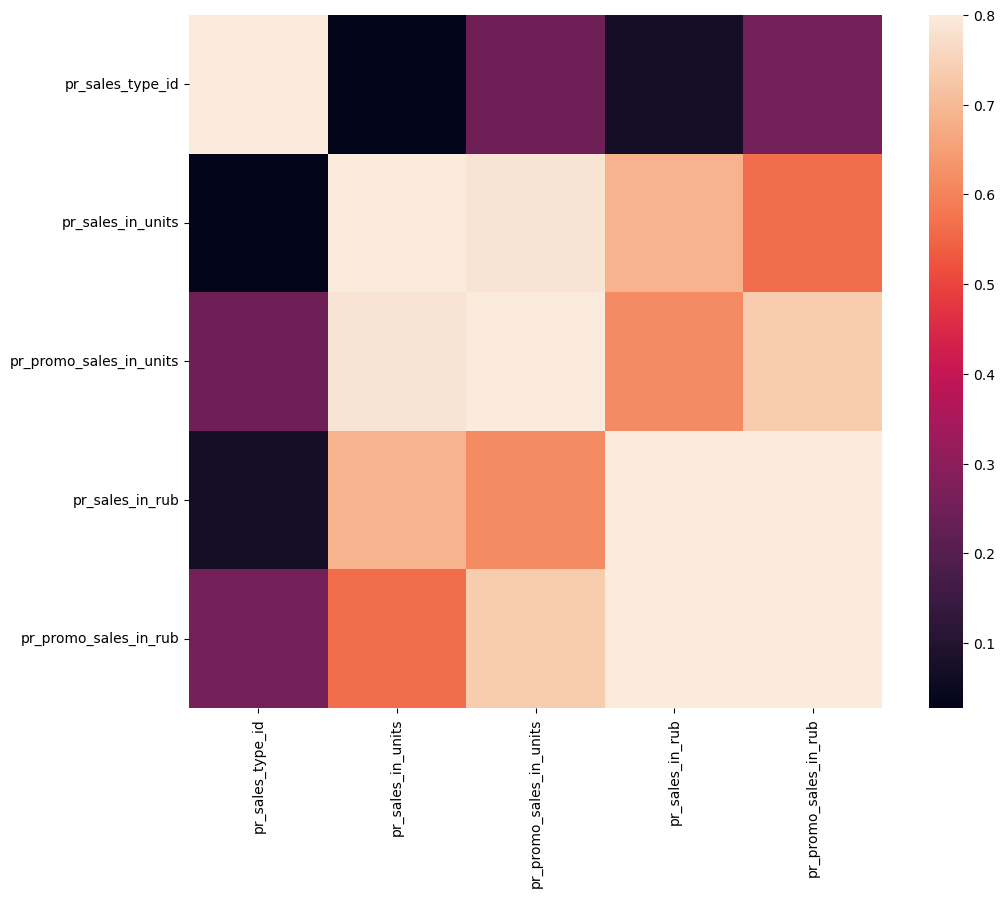

In [15]:
corrmat = sales.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Наблюдаем сильную корреляцию между признаками продаж с промо и без. Они несут одинаковую информацию, поэтому спокойно один из них можем удалить. Бинарный признак с данными о наличии акции уже есть

In [16]:
sales.rename(columns={'st_id': 'st_id', 'date': 'date', 'pr_sku_id': 'pr_sku_id', 'pr_sales_type_id': 'pr_sales_type_id',
                     'pr_sales_in_units': 'sales_in_units', 'pr_sales_in_rub': 'sales_in_rub'}, inplace=True)

sales.drop(['pr_promo_sales_in_units', 'pr_promo_sales_in_rub'], axis=1, inplace=True)

sales.shape

(882936, 6)

На данном этапе с предобработкой продаж закончили. Переходим к следующим дата-фреймам 

In [17]:
inactive = stores[stores['st_is_active'] == 0]
inactive

,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,1aa057313c28fa4a40c5bc084b11d276,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,19,0
10,62f91ce9b820a491ee78c108636db089,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,32,0


Два неактивных магазина. Удалим данные по их продажам из основной таблицы sales

In [18]:
sales = sales.query('st_id != "1aa057313c28fa4a40c5bc084b11d276" & st_id != "62f91ce9b820a491ee78c108636db089"')
sales.shape

(882207, 6)

### Выводы

- Удалось выявить зависимость в переменных, которые могли привести к мультиколлинеарности: два признака, по сути объясняли одно и тоже: продажи по акции и без. Один из них удалили
- Также мы удалили отрицательные продажи, так как они появились из-за возврата товаров. Возвраты не являются для бизнеса важным элементом для прогнозирования, поэтому мы приняли решение их удалить. К тому же, их процент в данных минимальный: о т0,4% до 0,8%. процентов. 
- Удалили записи о неактивных магазинах. Их данные при прогнозировании не важны для решения бизнес-задачи


## EDA

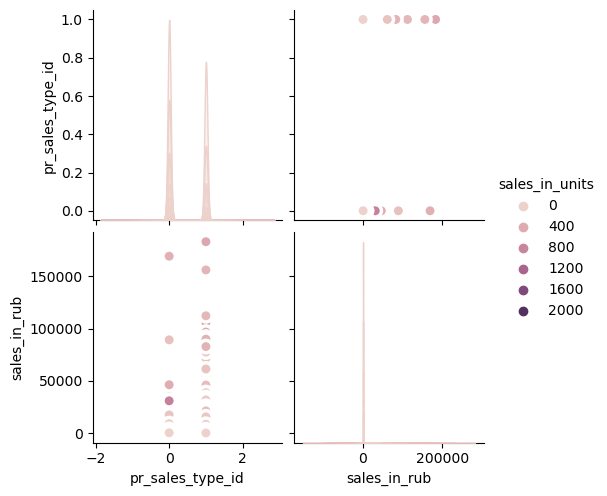

In [19]:
sns.pairplot(sales, kind="scatter", hue="sales_in_units", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()


In [20]:
sales.columns

Index(['st_id', 'pr_sku_id', 'pr_sales_type_id', 'sales_in_units',
       'sales_in_rub', 'dates'],
      dtype='object')

### Анализ продаж по акции или без

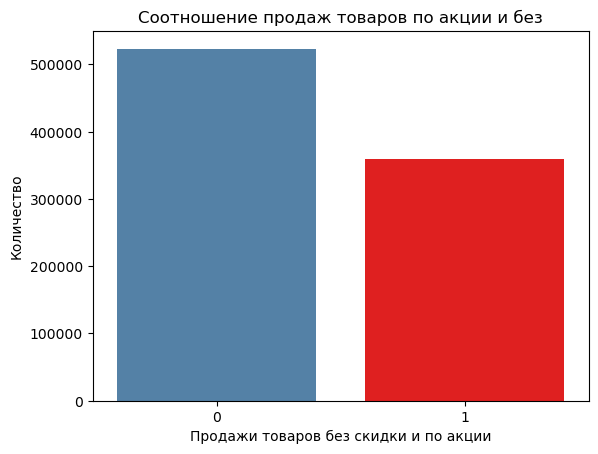

In [21]:
counts = sales['pr_sales_type_id'].value_counts()

colors = ['steelblue', 'red']

sns.barplot(x=counts.index, y=counts.values, palette=colors)

plt.xlabel('Продажи товаров без скидки и по акции')
plt.ylabel('Количество')
plt.title('Соотношение продаж товаров по акции и без')
plt.xticks(counts.index)
plt.show()


Продаж без скидки больше, чем по акции. Скорее это вызвано тем, что акции происходят не каждый день, а с определенной периодичностью. Выясним, влияют ли проведение акций на выброс в данных

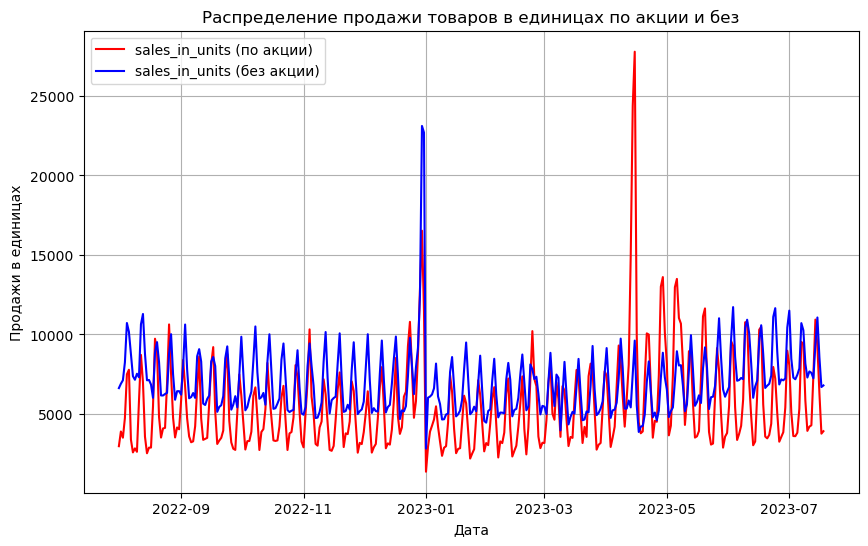

In [22]:
plt.figure(figsize=(10, 6))

# Фильтрация данных для праздничных и непраздничных дней
promo_sales = sales[sales['pr_sales_type_id'] == 1]
non_promo_sales = sales[sales['pr_sales_type_id'] == 0]

# Ресемплирование по дням для обоих случаев
promo_sales = promo_sales.resample('D').sum()
non_promo_sales = non_promo_sales.resample('D').sum()

# Построение графиков
plt.plot(promo_sales.index, promo_sales['sales_in_units'], label='sales_in_units (по акции)', color='red')
plt.plot(non_promo_sales.index, non_promo_sales['sales_in_units'], label='sales_in_units (без акции)', color='blue')

plt.title('Распределение продажи товаров в единицах по акции и без')
plt.xlabel('Дата')
plt.ylabel('Продажи в единицах')
plt.legend()
plt.grid(True)
plt.show();

Наблюдаем, что большинство выбросов продаж товаров по акции выпало на вторую половину апреля и достигло максимальных продаж за весь период. Проверим, что это за категория товаров

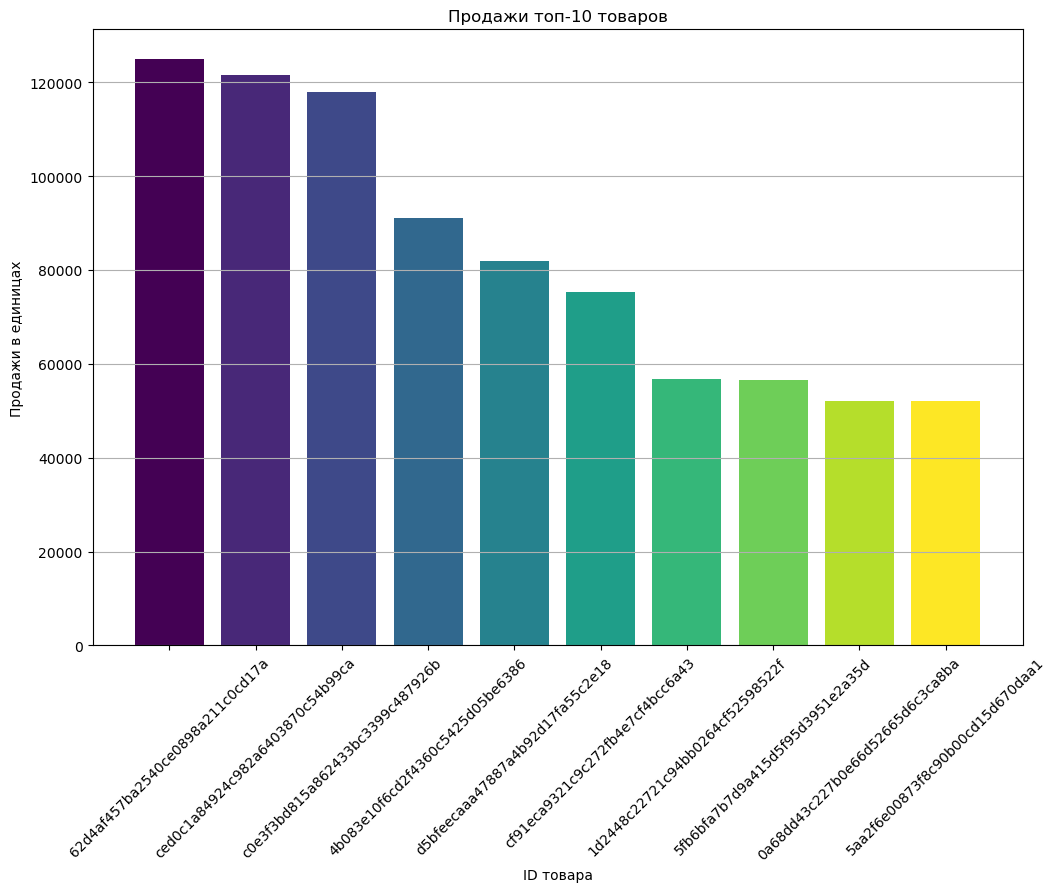

In [23]:
top_goods = sales.groupby('pr_sku_id')['sales_in_units'].sum().nlargest(10)

# Создание цветового градиента
colors = plt.cm.viridis(np.linspace(0, 1, len(top_goods)))

# Создание столбчатой диаграммы с градиентными цветами
plt.figure(figsize=(12, 8))
plt.bar(top_goods.index, top_goods.values, color=colors)

plt.title('Продажи топ-10 товаров')
plt.xlabel('ID товара')
plt.ylabel('Продажи в единицах')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### Распределение топ 6 товаров со скользящим средним 

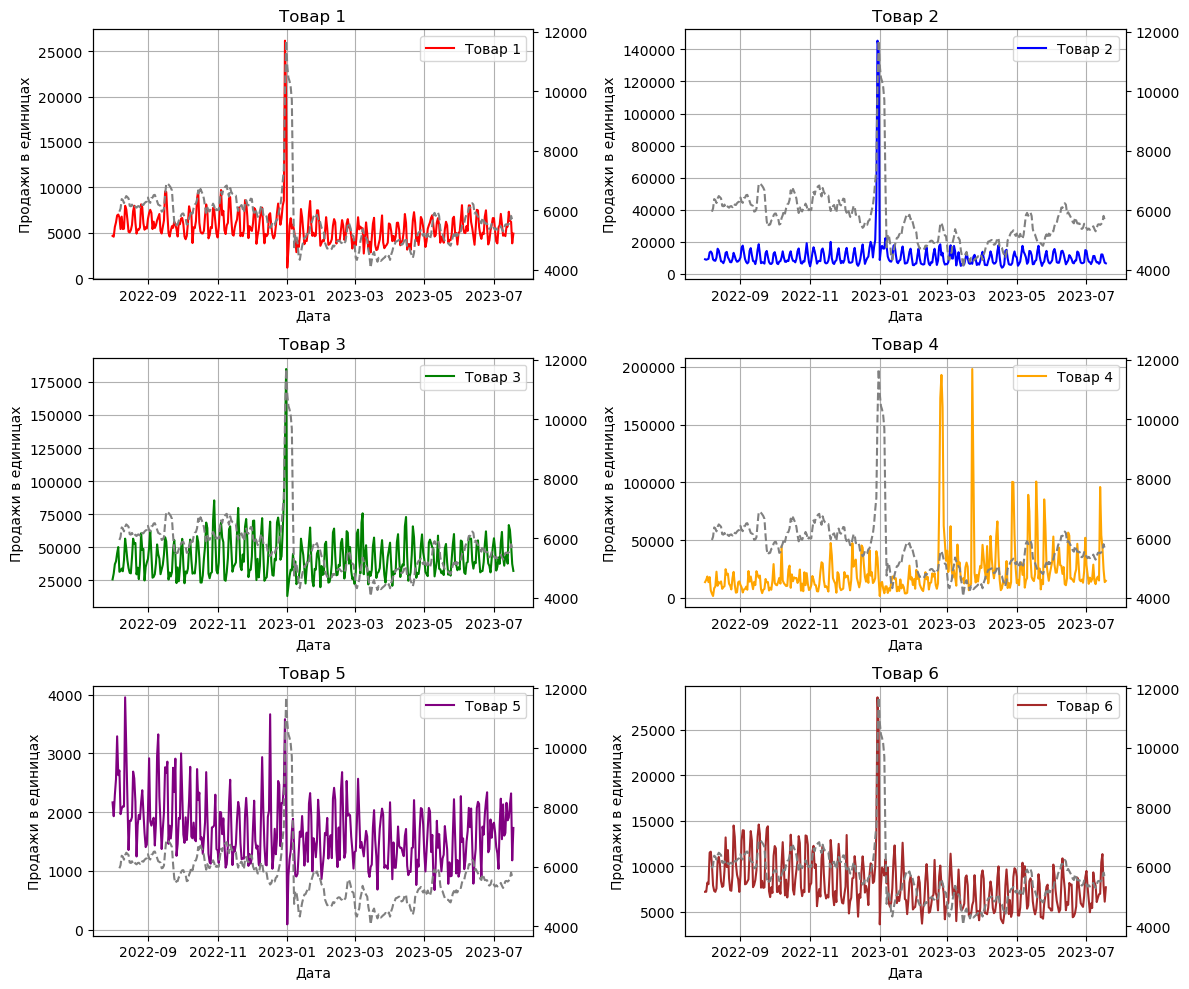

In [24]:
top_1 = sales[sales['pr_sku_id'] == '62d4af457ba2540ce0898a211c0cd17a']
top_2 = sales[sales['pr_sku_id'] == 'ced0c1a84924c982a6403870c54b99ca']
top_3 = sales[sales['pr_sku_id'] == 'c0e3f3bd815a862433bc3399c487926b']
top_4 = sales[sales['pr_sku_id'] == '4b083e10f6cd2f4360c5425d05be6386']
top_5 = sales[sales['pr_sku_id'] == 'd5bfeecaaa47887a4b92d17fa55c2e18']
top_6 = sales[sales['pr_sku_id'] == 'cf91eca9321c9c272fb4e7cf4bcc6a43']


top_1 = top_1.resample('D').sum()
top_2 = top_2.resample('D').sum()
top_3 = top_3.resample('D').sum()
top_4 = top_4.resample('D').sum()
top_5 = top_5.resample('D').sum()
top_6 = top_6.resample('D').sum()


num_rows = 3
num_columns = 2
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 10))


tops = [top_1, top_2, top_3, top_4, top_5, top_6]
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
titles = ['Товар 1', 'Товар 2', 'Товар 3', 'Товар 4', 'Товар 5', 'Товар 6']

for i in range(len(tops)):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row, col]
    
    ax.plot(tops[i].index, tops[i]['sales_in_rub'], label=f'Товар {i+1}', color=colors[i])
    ax.set_title(titles[i])
    ax.set_xlabel('Дата')
    ax.set_ylabel('Продажи в единицах')
    ax.grid(True)
    ax.legend()


for i in range(len(tops), num_rows * num_columns):
    row = i // num_columns
    col = i % num_columns
    axes[row, col].axis('off')
    
window_size = 7  # Размер окна для скользящего среднего
for ax in axes.flat:
    ax.grid(True)
    rolling_mean = ax.twinx()
    rolling_mean.plot(
        top_1.index, top_1['sales_in_rub'].rolling(window=window_size).mean(),
        linestyle='--', color='gray', label='Rolling Mean (top 1)'
    )

plt.tight_layout()
plt.show();

У большинство товаров пик приходится на 1 января 

### Праздничные дни

In [25]:
import holidays
russian_holidays = holidays.CountryHoliday('RU', prov=None, observed=True)

sales['is_holiday'] = sales['dates'].apply(lambda x: x in russian_holidays)

Проверка

In [26]:
date_to_check = date(2022, 9, 1)
if date_to_check in russian_holidays:
    print(f"{date_to_check} - Праздник!")
else:
    print(f"{date_to_check} - Не праздник.")

2022-09-01 - Не праздник.


In [27]:
sales['is_holiday'] = sales['is_holiday'].astype(int)
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 882207 entries, 2022-10-20 to 2023-01-19
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   st_id             882207 non-null  object 
 1   pr_sku_id         882207 non-null  object 
 2   pr_sales_type_id  882207 non-null  int64  
 3   sales_in_units    882207 non-null  float64
 4   sales_in_rub      882207 non-null  float64
 5   dates             882207 non-null  object 
 6   is_holiday        882207 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 53.8+ MB


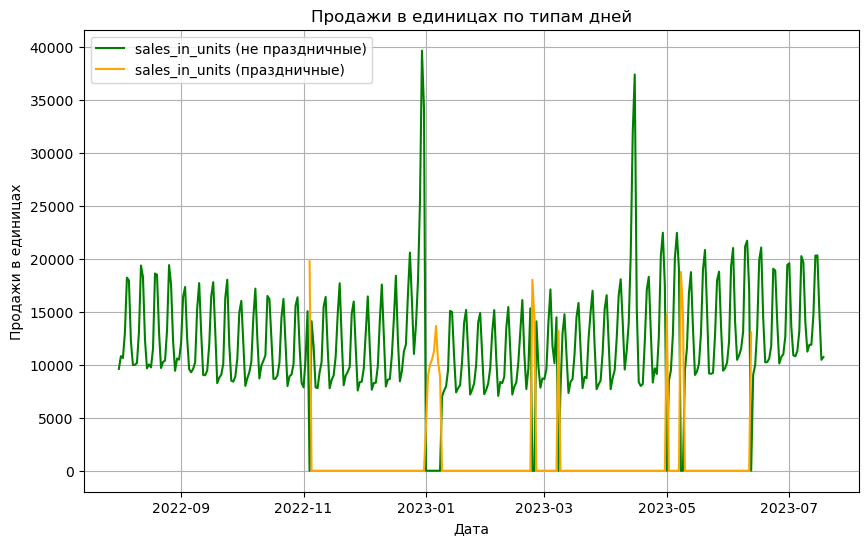

In [28]:
plt.figure(figsize=(10, 6))

# Фильтрация данных для праздничных и непраздничных дней
holiday_sales = sales[sales['is_holiday'] == 0]
non_holiday_sales = sales[sales['is_holiday'] == 1]

# Ресемплирование по дням для обоих случаев
holiday_sales = holiday_sales.resample('D').sum()
non_holiday_sales = non_holiday_sales.resample('D').sum()

# Построение графиков
plt.plot(holiday_sales.index, holiday_sales['sales_in_units'], label='sales_in_units (не праздничные)', color='green')
plt.plot(non_holiday_sales.index, non_holiday_sales['sales_in_units'], label='sales_in_units (праздничные)', color='orange')

plt.title('Продажи в единицах по типам дней')
plt.xlabel('Дата')
plt.ylabel('Продажи в единицах')
plt.legend()
plt.grid(True)
plt.show();


Наблюдаем, что пик по продажам происходит до всероссийских праздников, а не в день. Рассмотрим более детально периоды майских и новогодних праздников. Именно в эти периоды выбросы не в день праздника, а до

### Продажи в новогодний период

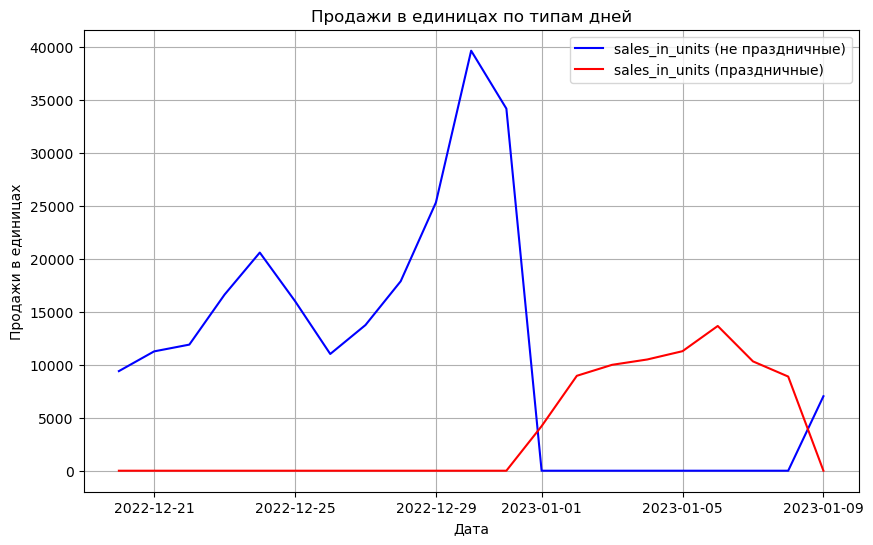

In [29]:
plt.figure(figsize=(10, 6))

# Фильтрация данных для праздничных и непраздничных дней
holiday_sales = sales[sales['is_holiday'] == 0]
non_holiday_sales = sales[sales['is_holiday'] == 1]

# Ресемплирование по дням для обоих случаев
holiday_sales = holiday_sales.resample('D').sum()
non_holiday_sales = non_holiday_sales.resample('D').sum()

# Устанавливаем период с 25 декабря 2022 по 9 января 2023
start_date = '2022-12-20'
end_date = '2023-01-09'

holiday_sales = holiday_sales[start_date:end_date]
non_holiday_sales = non_holiday_sales[start_date:end_date]

# Построение графиков
plt.plot(holiday_sales.index, holiday_sales['sales_in_units'], label='sales_in_units (не праздничные)', color='blue')
plt.plot(non_holiday_sales.index, non_holiday_sales['sales_in_units'], label='sales_in_units (праздничные)', color='red')

plt.title('Продажи в единицах по типам дней')
plt.xlabel('Дата')
plt.ylabel('Продажи в единицах')
plt.legend()
plt.grid(True)
plt.show()

### Майские праздники (1 мая)

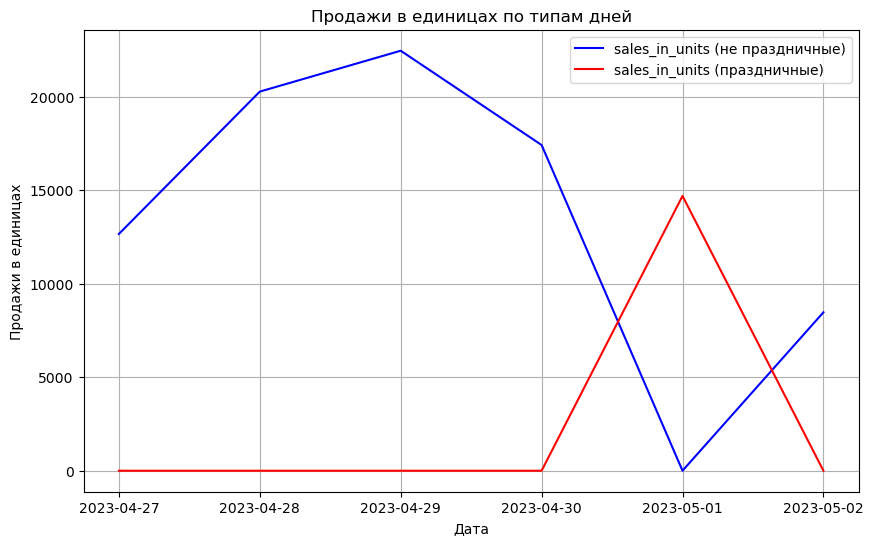

In [30]:
plt.figure(figsize=(10, 6))

# Фильтрация данных для праздничных и непраздничных дней
holiday_sales = sales[sales['is_holiday'] == 0]
non_holiday_sales = sales[sales['is_holiday'] == 1]

# Ресемплирование по дням для обоих случаев
holiday_sales = holiday_sales.resample('D').sum()
non_holiday_sales = non_holiday_sales.resample('D').sum()

# Устанавливаем период с 25 декабря 2022 по 9 января 2023
start_date = '2023-04-27'
end_date = '2023-05-02'

holiday_sales = holiday_sales[start_date:end_date]
non_holiday_sales = non_holiday_sales[start_date:end_date]

# Построение графиков
plt.plot(holiday_sales.index, holiday_sales['sales_in_units'], label='sales_in_units (не праздничные)', color='blue')
plt.plot(non_holiday_sales.index, non_holiday_sales['sales_in_units'], label='sales_in_units (праздничные)', color='red')

plt.title('Продажи в единицах по типам дней')
plt.xlabel('Дата')
plt.ylabel('Продажи в единицах')
plt.legend()
plt.grid(True)
plt.show()

### Майские праздники (9 мая)

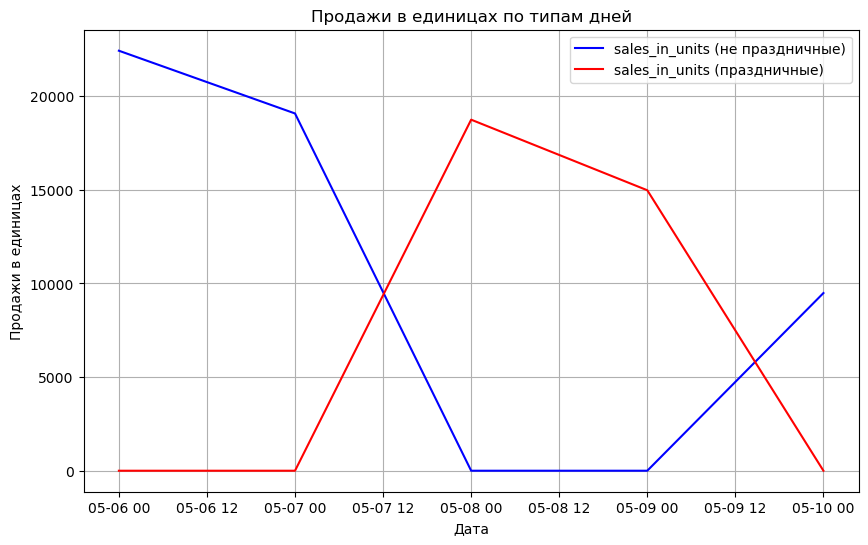

In [31]:
plt.figure(figsize=(10, 6))

# Фильтрация данных для праздничных и непраздничных дней
holiday_sales = sales[sales['is_holiday'] == 0]
non_holiday_sales = sales[sales['is_holiday'] == 1]

# Ресемплирование по дням для обоих случаев
holiday_sales = holiday_sales.resample('D').sum()
non_holiday_sales = non_holiday_sales.resample('D').sum()

# Устанавливаем период с 25 декабря 2022 по 9 января 2023
start_date = '2023-05-06'
end_date = '2023-05-10'

holiday_sales = holiday_sales[start_date:end_date]
non_holiday_sales = non_holiday_sales[start_date:end_date]

# Построение графиков
plt.plot(holiday_sales.index, holiday_sales['sales_in_units'], label='sales_in_units (не праздничные)', color='blue')
plt.plot(non_holiday_sales.index, non_holiday_sales['sales_in_units'], label='sales_in_units (праздничные)', color='red')

plt.title('Продажи в единицах по типам дней')
plt.xlabel('Дата')
plt.ylabel('Продажи в единицах')
plt.legend()
plt.grid(True)
plt.show()

Гипотеза подтвердилась. Продажи на новогодние и майские выше за день-два до праздника и снижаются в сам праздник и под конец

### Исследование магазинов

#### Топ 50 магазинов 

In [32]:
by_pair = sales.groupby('st_id')[['sales_in_units', 'sales_in_rub']].agg(['sum', 'count'])
all_sales = by_pair[('sales_in_rub', 'sum')].sum()
by_pair['all_sales_share'] = by_pair[('sales_in_rub', 'sum')] / all_sales * 100
by_pair.sort_values([('sales_in_units', 'sum')], ascending=False).head(50)

sales_in_units         sales_in_rub          \
                                            sum   count          sum   count   
st_id                                                                          
c81e728d9d4c2f636f067f89cc14862c       958883.0  174667  110214951.0  174667   
16a5cdae362b8d27a1d8f8c7b78b4330       872754.0  157530  108555870.0  157530   
42a0e188f5033bc65bf8d78622277c4e       725656.0  140276   91272766.0  140276   
f7e6c85504ce6e82442c770f7c8606f0       673708.0  124135   76250156.0  124135   
fa7cdfad1a5aaf8370ebeda47a1ff1c3       532039.0  110531   65016015.0  110531   
6364d3f0f495b6ab9dcf8d3b5c6e0b01       529951.0  115812   65854957.0  115812   
1ecfb463472ec9115b10c292ef8bc986       129190.0   47401    8354660.0   47401   
53e19f3dbb211f20b20b45668303c1b6        19227.0    9231    1084411.0    9231   
bd470ca955d9497bbcb808e59952fffc         5114.0    2586     256887.0    2586   
084a8a9aa8cced9175bd07bc44998e75           49.0      38       6836.0      38   

                                 all_sales_share  
                                                  
st_id                                             
c81e728d9d4c2f636f067f89cc14862c       20.918912  
16a5cdae362b8d27a1d8f8c7b78b4330       20.604017  
42a0e188f5033bc65bf8d78622277c4e       17.323666  
f7e6c85504ce6e82442c770f7c8606f0       14.472359  
fa7cdfad1a5aaf8370ebeda47a1ff1c3       12.340107  
6364d3f0f495b6ab9dcf8d3b5c6e0b01       12.499339  
1ecfb463472ec9115b10c292ef8bc986        1.585723  
53e19f3dbb211f20b20b45668303c1b6        0.205822  
bd470ca955d9497bbcb808e59952fffc        0.048757  
084a8a9aa8cced9175bd07bc44998e75        0.001297

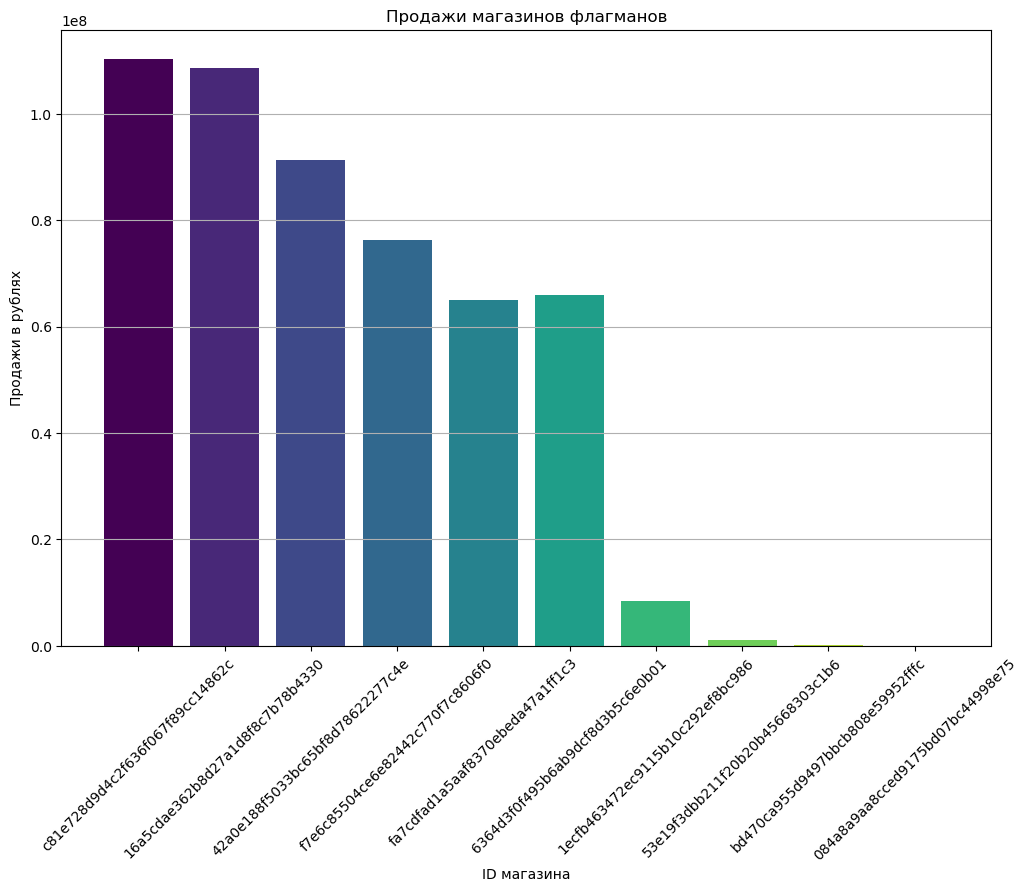

In [33]:
by_pair = sales.groupby('st_id')[['sales_in_units', 'sales_in_rub']].agg(['sum', 'count'])
all_sales = by_pair[('sales_in_rub', 'sum')].sum()
by_pair['all_sales_share'] = by_pair[('sales_in_rub', 'sum')] / all_sales * 100
top_stores = by_pair.sort_values([('sales_in_units', 'sum')], ascending=False).head(50)

# Создание цветового градиента
colors = plt.cm.viridis(np.linspace(0, 1, len(top_stores)))

# Создание столбчатой диаграммы с градиентными цветами
plt.figure(figsize=(12, 8))
plt.bar(top_stores.index, top_stores[('sales_in_rub', 'sum')], color=colors)

plt.title('Продажи магазинов флагманов')
plt.xlabel('ID магазина')
plt.ylabel('Продажи в рублях')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Наблюдаем высокие продажи только у 6 магазинов. Исследуем, почему так произошло

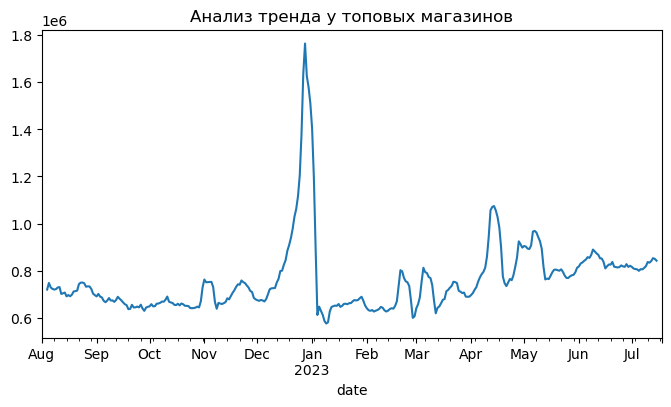

In [42]:
sellers_list = ['c81e728d9d4c2f636f067f89cc14862c', '6a5cdae362b8d27a1d8f8c7b78b4330', '42a0e188f5033bc65bf8d78622277c4e', '7e6c85504ce6e82442c770f7c8606f0', 'a7cdfad1a5aaf8370ebeda47a1ff1c3',
               '6364d3f0f495b6ab9dcf8d3b5c6e0b01']
top_sellers = sales[sales['st_id'].isin(sellers_list)]
decomposed_trend = seasonal_decompose(top_sellers['sales_in_rub'].resample('D').sum())
 
plt.figure(figsize=(8, 4))
ax = decomposed_trend.trend.plot()
ax.set_title('Анализ тренда у топовых магазинов')
plt.show()

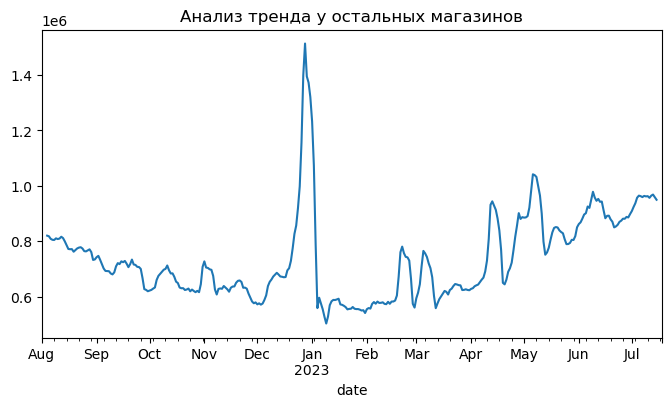

In [35]:
main_sellers = sales[~sales['st_id'].isin(sellers_list)]
decomposed_trend = seasonal_decompose(main_sellers['sales_in_rub'].resample('D').sum())
 
plt.figure(figsize=(8, 4))
ax = decomposed_trend.trend.plot()
ax.set_title('Анализ тренда у остальных магазинов')
plt.show()

Тренд у топовых магазинов и остальных в целом очень похож, однако именно в праздничные дни топовые магазины продали больше товаров, что и обеспечивает их лидерство среди других. Возможно повлиял график работы магазинов или их расположение (например, спальные районы). Есть гипотеза, что у топовых магазинов меньше товаров по акции, что и обеспечивает рост выручки. Исследуем 

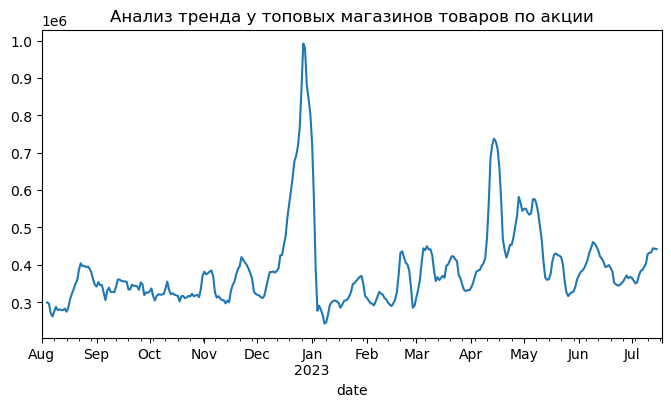

In [44]:
top_sellers = sales[(sales['st_id'].isin(sellers_list)) & (sales['pr_sales_type_id'] == 1)]
resampled_sales = top_sellers['sales_in_rub'].resample('D').sum()
decomposed_trend = seasonal_decompose(resampled_sales)

plt.figure(figsize=(8, 4))
ax = decomposed_trend.trend.plot()
ax.set_title('Анализ тренда у топовых магазинов товаров по акции')
plt.show()

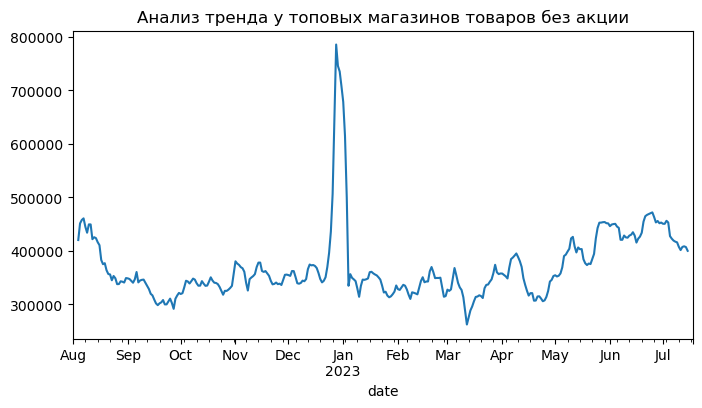

In [45]:
top_sellers = sales[(sales['st_id'].isin(sellers_list)) & (sales['pr_sales_type_id'] == 0)]
resampled_sales = top_sellers['sales_in_rub'].resample('D').sum()
decomposed_trend = seasonal_decompose(resampled_sales)

plt.figure(figsize=(8, 4))
ax = decomposed_trend.trend.plot()
ax.set_title('Анализ тренда у топовых магазинов товаров без акции')
plt.show()

Январские праздники в целом являются выбросами и по ним анализировать не стоит. Примечательно, что товары по акции были в период апреля, когда мы заметили увеличение продаж в единицах. Следовательно акция, которая, скорее предусматривала набор большего количества товаров, простимулировала продажи именно в штуках или кг

In [ ]:
main_sellers = sales[(~sales['st_id'].isin(sellers_list)) & (sales['pr_sales_type_id'] == 0)]
resampled_sales = top_sellers['sales_in_rub'].resample('D').sum()
decomposed_trend = seasonal_decompose(resampled_sales)

plt.figure(figsize=(8, 4))
ax = decomposed_trend.trend.plot()
ax.set_title('Анализ тренда у топовых магазинов товаров без акции')
plt.show()

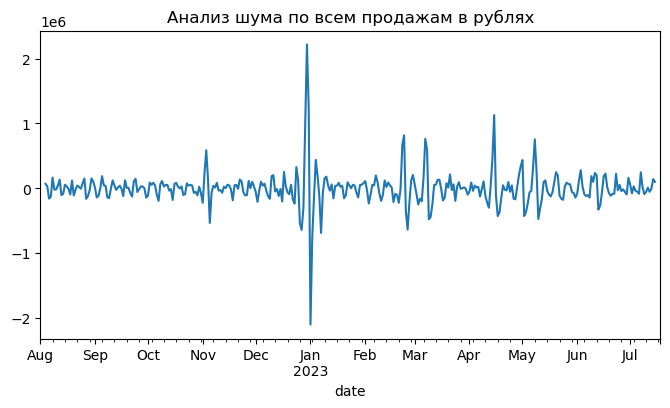

In [36]:
decomposed_resid = seasonal_decompose(sales['sales_in_rub'].resample('D').sum())
 
plt.figure(figsize=(8, 4))
ax = decomposed_resid.resid.plot(ax=plt.gca())
ax.set_title('Анализ шума по всем продажам в рублях')
plt.show()

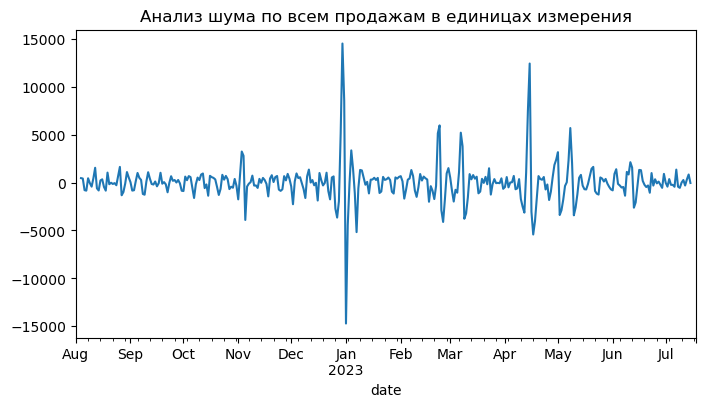

In [40]:
decomposed_resid = seasonal_decompose(sales['sales_in_units'].resample('D').sum())
 
plt.figure(figsize=(8, 4))
ax = decomposed_resid.resid.plot(ax=plt.gca())
ax.set_title('Анализ шума по всем продажам в единицах измерения')
plt.show()

Примечательно, что шум по продажам в единицах измерения появился в апреле (перед майскими праздниками) и выше, чем продажа в рублях. Возможно это из-за продажи товаров, закодированных поштучно (больше объема упаковок) или особенностью российских потребителей покупать больше еды для пикника именно перед майскими праздниками

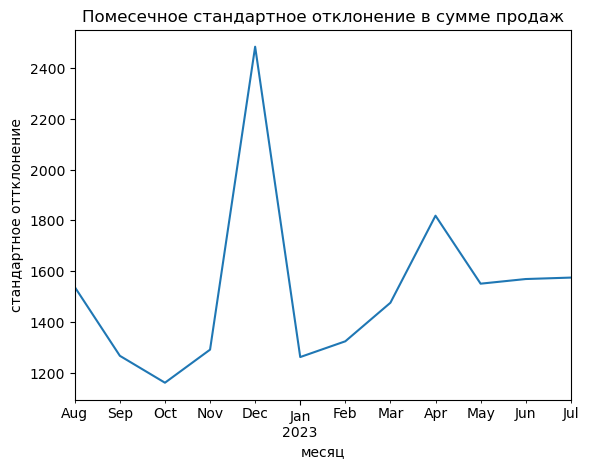

In [37]:
sales.resample('M')['sales_in_rub'].std().plot()
plt.title('Помесечное стандартное отклонение в сумме продаж')
plt.xlabel('месяц')
plt.ylabel('стандартное оттклонение')
plt.show()

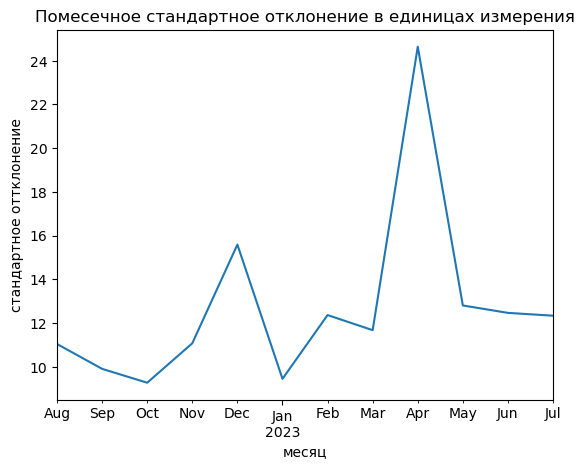

In [39]:
sales.resample('M')['sales_in_units'].std().plot()
plt.title('Помесечное стандартное отклонение в единицах измерения')
plt.xlabel('месяц')
plt.ylabel('стандартное оттклонение')
plt.show()

### Выводы

Инсайты, которые удалось достать: 
- Праздники влияют на продажи товаров. Примечательно, что продажи увеличиваются не в день праздника, который является производственным выходным, а за 2-3 дня до. Пиковыми продажами стали продажи в конце декабря и конце апреля
- Промоакции увеличивают продажи в шутках. Скорее всего они строятся по принципу: возьми больше – заплати меньше
- Из-за шума в январе и мае сложно прогнозировать продажи на основе этих периодов 
- Большинство продаж в магазинах без акции
- Мы выделили топ магазинов среди всех, чья выручка выше остальных. 